In [1]:

import os
import struct
import numpy as np
from matplotlib import pyplot

import matplotlib as mpl
import random
import matplotlib.pyplot as plt
import csv

#Fashion-MNIST classes (mapping from class index to class name)
class_names = ['tshirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# some utilities

def create_submission_file(fname, preds):
    """
    Create Kaggle submision with predictions written as a csv (comma separated values) file 
    """
    
    ofile  = open(fname, "w")
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)    
    
    writer.writerow(['id', 'label'])
    
    
    for i in range(preds.shape[0]):
        writer.writerow([i,preds[i]])
        

        
def read_fMNIST(dataset = "training", path = "./", load_small=False):
    """
    reading in the "Fashion MNIST" data
    this function allows specification of the part to be read (training/testing/validation)
    if load_small = True, this will look for the file(s) associated with the small training set
    Note that if dataset='testing', no labels will be returned
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'Tr'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'Vl'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'Te'
        has_labels = False

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    if load_small:
        file_name_suffix += '_sm'
    
    #Load the appropriate files
    X = np.load('./x'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load('./y'+file_name_suffix+'.npy')
    

    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X



def show_fMNIST_example(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    image = image[-28**2:]
    image = image.reshape(28,28)

    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.axis('off')
    pyplot.show()

Let's look at some images

Training images
Class: bag


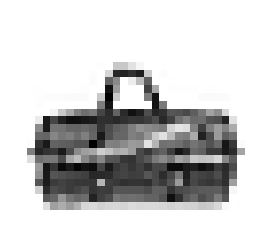

Class: shirt


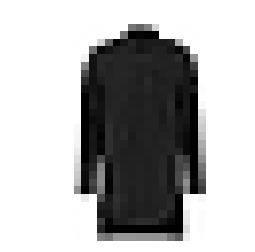

Validation images
Class: bag


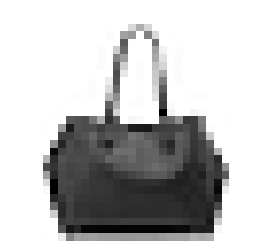

Class: sandal


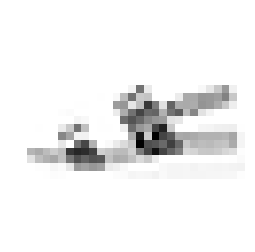

In [2]:

X,y = read_fMNIST('training')
print('Training images')
print('Class: %s'%class_names[np.argmax(y[10])])
show_fMNIST_example(X[10])
print('Class: %s'%class_names[np.argmax(y[20])])
show_fMNIST_example(X[20])


X,y = read_fMNIST('validation')
print('Validation images')
print('Class: %s'%class_names[np.argmax(y[10])])
show_fMNIST_example(X[10])
print('Class: %s'%class_names[np.argmax(y[20])])
show_fMNIST_example(X[20])



Now we will build the code for our softmax model

In [3]:
def softmax(scores):
    """
    takes the softmax along the second dimension of a matrix, returns class scores
    """
    # we will adjust the dynamic range by subtracting the max, to prevent potential underflow in exp
    exp_scores = np.exp(scores-np.max(scores,axis=1,keepdims=True))+1e-6
    return exp_scores/(np.sum(exp_scores,axis=1,keepdims=True))


def log_likelihood(X,w,y):
    """
    Inputs: 
      X: a Nxd matrix where each of the N rows is a datapont with d features
      Y: a Nx10 matrix, each row is a one-hot vector with the ith entry is 1 if that datapoint belongs to class i 
      w: is a dx1 matrix containing your model parameters
    Outputs:
      LL: a scalar containing the AVERAGE log-likelihood of the dataset's labels y, given inputs X and model w
    """
    #compute the un-normalized 'scores' of each class for each datapoint
    scores = infer(X,w)
    
    #normalize the scores to get a distribution over classes for each datapoint
    predictions = softmax(scores)
        
    #Use the predicted distributions, and the true distributions to compute log-likelihood
    N = y.shape[0]
    LL = 1/N * np.sum(- y * np.log(predictions))

    return LL

def objective(X,w,y):
    """
    Compute components of the optimization objective
    Output:
    logloss : value of log-loss (negative average log-likelihood)
    regularizer: value of the regularization term (Frobenius norm of w), NOT multiplied by lambda
    """
    regularizer = np.linalg.norm(w,'fro')
    logloss = - log_likelihood(X,w,y)
    return logloss, regularizer



def gradient(X,w,y):
    """
    Compute in grad the gradient of the log-loss of the model (w) given the features (X) and labels (y) w.r.t. w
    Also compute and return in l2grad the gradient of the regularizer lambda*norm(w)
    Note: we can't use the name 'lambda' since it's a keyword in Python
    Reminder: the full objective is -log p(y|X;w) + lmbda*norm2(w)
    """
    
    #Compute any extra variable needed to compute the gradient:
    scores = np.dot(X,w)
    predictions = softmax(scores)
    difference = (predictions - y)
    N = y.shape[0]

    #Compute the gradient of the average log-loss
    grad = 1/N * np.dot(X.T, difference)
    
    l2grad = 2 * w
    
    return grad, l2grad

def infer(X,w):
    """
    Compute the class scores that model w gives for each class, given data X
    """
    scores = np.dot(X,w)
    return scores

def accuracy(X,w,y):
    """
    Compute accuracy (one minus average 0/1 loss) of model w relative to true labels y on data X
    """
    y_hat = np.argmax(infer(X,w),axis=1)
    y = np.argmax(y,axis=1)
    acc = np.sum(np.equal(y,y_hat).astype(np.float32))/y.shape[0]
    return acc
        

Now we define the SGD (stochastic gradient descent) procedure for softmax, with optional regularization

In [4]:
def minibatch_sgd(xTr, yTr, xVl, yVl, lmbda=0, lr = .01,maxepochs=10,bsize=32,objTol=.01,verbose=1):
    
    # initialization of w (feel free to play with this)
    w = np.zeros((xTr.shape[1],yTr.shape[1]))
    
    old_obj = 1e9  
    old_w = w
    
    # we will organize the run in terms of epochs (one epcoh = one full pass over data)
    # to keep track of learning curves, allocate space
    trAcc = np.zeros(maxepochs)
    obj = np.zeros(maxepochs)
    
    for epoch in range(maxepochs):
        
        #shuffle the data
        index = np.random.permutation(xTr.shape[0])
        nBatches = np.floor(xTr.shape[0]/bsize).astype(np.integer) # ignore the remainder N-floor(N/bsize), for simplicity
    
        for b in range(nBatches):
            # fill in the batch
            iBatch = index[b*bsize:(b+1)*bsize]
            xBatch = xTr[iBatch]
            yBatch = yTr[iBatch]
            
            grad,l2grad = gradient(xBatch,w,yBatch)
    
            w = w-lr*(grad+lmbda*l2grad)
            
        
        # end of an epoch: test for convergence by looking at validation
        logloss, regularizer = objective(xTr,w,yTr)
        obj[epoch] = logloss+lmbda*regularizer
                
        # also record accuracy on training
        trAcc[epoch] = accuracy(xTr,w,yTr)

        obj_gain = (old_obj-obj[epoch])/np.abs(old_obj) # improvement in training objective this epoch
        
        if verbose > 0.5:
            print('Epoch %d: obj=%.4f, gain %.4f  [train acc %.4f]'%(epoch,obj[epoch],obj_gain,trAcc[epoch]))
        
        
        if epoch == maxepochs-1:
            if verbose > 0:
                print('Reached max epochs, stopping')
            return w, obj, trAcc
        
        if obj_gain < objTol:  
            lr = lr/2
            if verbose > 0:
                print('Dropping learning rate to %.4f'%lr)
        
        # update bookkeeping before going to next epoch
        old_obj = obj[epoch]    
    

Before we can start experiments, we need one more piece: feature transform. In this case we are using the "raw" features (pixel values) plus the constant term, but with normalization that applies z-scoring to each pixel.

In [5]:
# if mu and sigma are provided, they are used to normalize each pixel
# otherwise, they are computed and returned
def preprocess_data(X,mu = None,sigma = None,visualize=False):

    if visualize:
        print('VISUALIZE BEFORE NORMALIZATION')
        #Visualize example before normalization
        show_fMNIST_example(X[300])
        show_fMNIST_example(X[500])
    
    if mu is None: # need to compute normalizing stats
        compute_stats = True
        mu = X.mean(axis=0, keepdims=True)
        sigma = X.std(axis=0, keepdims=True)
        sigma[np.equal(sigma,0)]=1.0 # avoid division by zero in case of degenerate features
    else:
        compute_stats = False
        
    #Normalize the data
    X = (X-mu)/sigma
    bias_feature = np.ones((X.shape[0],1))
    X = np.concatenate([np.ones((X.shape[0],1)),X],1)

    if visualize:
        print('VISUALIZE AFTER NORMALIZATION')
        #Visualize example after normalization
        show_fMNIST_example(X[300])
        show_fMNIST_example(X[500])
    
    if compute_stats:
        return X, mu, sigma
    else:
        return X




VISUALIZE BEFORE NORMALIZATION


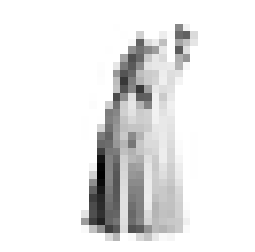

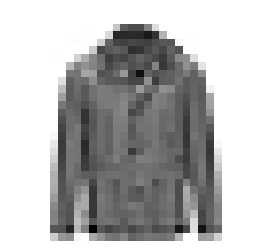

VISUALIZE AFTER NORMALIZATION


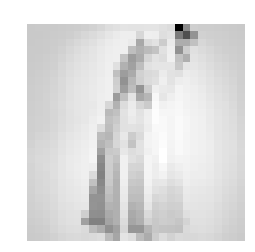

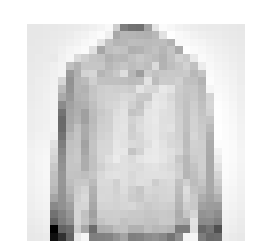

In [6]:
xTr, yTr = read_fMNIST('Training')
xTr, mu, sigma = preprocess_data(xTr,visualize=True)

We now define the main routine for our experiments: load training/validation data sets, and tune the regularization parameter (and perhaps other parameters you want to tune)

In [14]:
# run minibatch SGD for every value of lambda and record training/val accuracy
def tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt):
    
    obj=dict()
    trAcc=dict()
    model=dict()
    valAcc=dict()

    for lmbda in lambdas:
        for b in sgd_opt['bsize']:
            for epchs in sgd_opt['maxepochs']:
                for l in sgd_opt['lr']:
                    mod, o, trA = minibatch_sgd(xTr,yTr,xVl,yVl,lmbda, l, epchs ,b ,verbose=sgd_opt['verbose'])
                    vA = accuracy(xVl,mod,yVl)
                    if lmbda in valAcc:
                        if valAcc[lmbda] < vA:
                            valAcc[lmbda] = vA
                            model[lmbda] = mod
                            obj[lmbda] = o
                            trAcc[lmbda] = trA
                    else:
                        valAcc[lmbda] = vA
                        model[lmbda] = mod
                        obj[lmbda] = obj
                        trAcc[lmbda] = trA
                    
                    if sgd_opt['verbose'] >= 0:
                        print('-------------- lambda=%.5f, epchs=%.1f, bsize=%.1f, lr=%.2f, val Acc = %.4f  (tr Acc = %.4f)'%(lmbda,epchs,b,l,vA,trA[-1]))

    return model, obj, trAcc, valAcc

In [15]:
xTr, yTr = read_fMNIST('Training')
xVl, yVl = read_fMNIST('Validation')

xTr,mu,sigma = preprocess_data(xTr,visualize=False)
xVl = preprocess_data(xVl,mu,sigma,visualize=False)

# values below are a recommendation for initial exploration -- you should see if you want to refine these

lambdas = [.0001,.0015,.0017, .0018, .0019]
sgd_opt = sgd_opt = {'bsize':[10,50], 'maxepochs':[10,30], 'lr':[.08,.1],'verbose':0}


model, obj, trAcc, valAcc = tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)

minAcc = 0
for key in model.keys():
    if valAcc[key] > minAcc:
        minAcc = valAcc[key]
        best = key
        
print(best, valAcc[best], "I am the best")

-------------- lambda=0.00010, epchs=10.0, bsize=10.0, lr=0.08, val Acc = 0.8446  (tr Acc = 0.8769)
-------------- lambda=0.00010, epchs=10.0, bsize=10.0, lr=0.10, val Acc = 0.8328  (tr Acc = 0.8642)
-------------- lambda=0.00010, epchs=30.0, bsize=10.0, lr=0.08, val Acc = 0.8494  (tr Acc = 0.8830)
-------------- lambda=0.00010, epchs=30.0, bsize=10.0, lr=0.10, val Acc = 0.8472  (tr Acc = 0.8829)
-------------- lambda=0.00010, epchs=10.0, bsize=50.0, lr=0.08, val Acc = 0.8545  (tr Acc = 0.8753)
-------------- lambda=0.00010, epchs=10.0, bsize=50.0, lr=0.10, val Acc = 0.8537  (tr Acc = 0.8765)
-------------- lambda=0.00010, epchs=30.0, bsize=50.0, lr=0.08, val Acc = 0.8536  (tr Acc = 0.8778)
-------------- lambda=0.00010, epchs=30.0, bsize=50.0, lr=0.10, val Acc = 0.8527  (tr Acc = 0.8790)
-------------- lambda=0.00150, epchs=10.0, bsize=10.0, lr=0.08, val Acc = 0.8518  (tr Acc = 0.8705)
-------------- lambda=0.00150, epchs=10.0, bsize=10.0, lr=0.10, val Acc = 0.8457  (tr Acc = 0.8657)


### Summary of Experiments

- Created a grid search by changing the tune_regularization function.

- Explored values of lambda between 0.001 and 0.01 after realizing that values of lambda greater than 0.01 were not improving accuracy on the validation set.

- Tried different values for the learning rate, but the results for values between 0.02 and 0.1 did not show improvements on the accuracy for the validation set.

- Increased size of the batch. Given that the large training set contains more information, increasing the batch size improved accuracy, while holding everything else constant. However, improvements ceased when the batch size was too large (greater than 200).

- Increasing the value of the epochs beyond 30 showed marginal improvements.

Select the best model and use it to generate predictions for test data (to be submitted to Kaggle)

In [16]:
xTe = read_fMNIST('testing')
xTe = preprocess_data(xTe,mu,sigma,visualize=False)


#Decide which model you want to use for your submission
chosen_model_lrg = model[best]

#Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe,chosen_model_lrg),axis=1)
create_submission_file('./large_submission.csv', final_preds)

### Best Model for Large Validation Set
 
 - Lambda equal to 0.017
 - Accuracy on Validation Set 0.8556

In [17]:
# Useful functions for data visualization
def visualize(w, c):
    '''
    To show the vector wc associated with class c in model W.
    '''
    plt.imshow(w[-28**2:, c].reshape(28, 28), cmap = mpl.cm.Greys)
    plt.colorbar()
    plt.show()
    
# Function for Confusion matrix   

def confuse_me (predictions, labels):
    
    '''
    Takes in an array of prediction and a list of labels.
    Produces confusion matrix
    '''
    confusion_matrix = np.zeros((10,10))[:: -1]
    for i,j in zip(labels, predictions):
        confusion_matrix[i][j]+=1
        
    fig, ax = plt.subplots()
    plt.imshow(np.flip(np.flip(confusion_matrix,1),0), cmap ="inferno")
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_yticklabels(class_names)
    ax.set_xticklabels(class_names,rotation = 90)
    plt.colorbar()
    plt.show()


## Confusion Matrix on the Large Validation Set

In [18]:
final_preds = np.argmax(infer(xVl,chosen_model_lrg),axis=1)
labels = [j for i in range(yVl.shape[0])for j in range(yVl.shape[1]) if yVl[i][j] == 1]

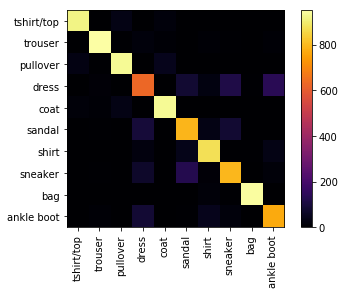

In [19]:
confuse_me (final_preds, labels)

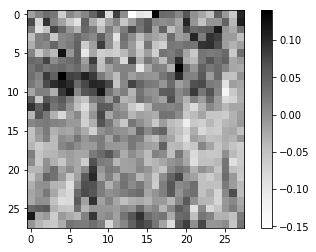

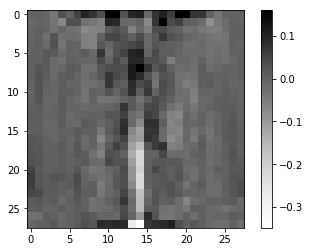

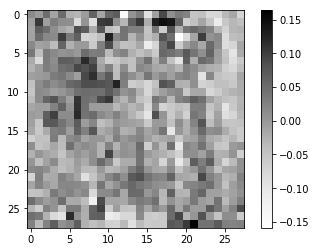

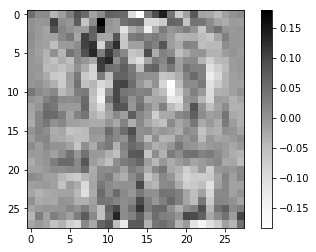

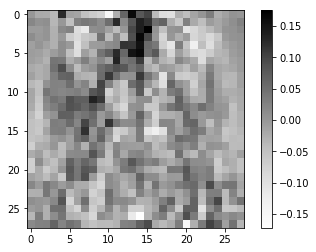

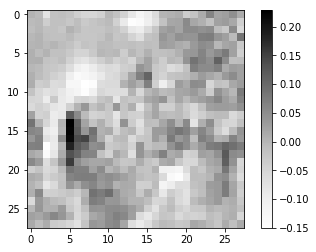

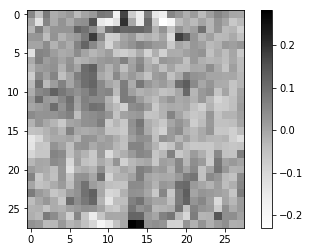

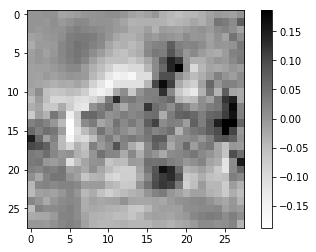

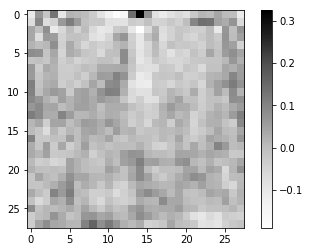

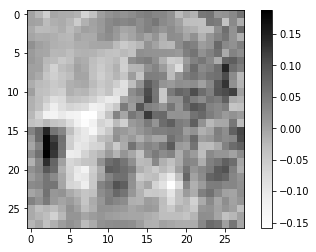

In [20]:
for i in range(10):
    visualize(chosen_model_lrg, i)

## Interpretation

We split the image into 28x28 pixels. Each pixel corresponds to a weight. We visualize the weights. The higher the weight, the darker the corresponding pixel. The higher the weight, the more our score increases if an image shows something in that pixel.

- The visualize function shows the predicted values for a particular class with our best model.
- For example, the class with value one corresponds to trousers.
- The second plot shows an image which looks similar to the trouser class.
- If I change the value of c, I can visualize the predicted values for a different class.

Now we will repeat this experiment with the small training set

In [22]:
xTr, yTr = read_fMNIST('Training', load_small=True)
xVl, yVl = read_fMNIST('Validation')


xTr,mu,sigma = preprocess_data(xTr,visualize=False)
xVl = preprocess_data(xVl,mu,sigma,visualize=False)

lambdas = [0,.0001,.001,.01,.1, 1.0,10.0]
sgd_opt = {'bsize':[5,10], 'maxepochs':[10,30], 'lr':[0.8, .1],'verbose':0}


model, obj, trAcc, valAcc = tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)

minAcc = 0
for key in model.keys():
    if valAcc[key] > minAcc:
        minAcc = valAcc[key]
        best2 = key
print(best2, valAcc[best2], "I am the best")

-------------- lambda=0.00000, epchs=10.0, bsize=5.0, lr=0.80, val Acc = 0.5135  (tr Acc = 1.0000)
-------------- lambda=0.00000, epchs=10.0, bsize=5.0, lr=0.10, val Acc = 0.4877  (tr Acc = 1.0000)
-------------- lambda=0.00000, epchs=30.0, bsize=5.0, lr=0.80, val Acc = 0.4594  (tr Acc = 1.0000)
-------------- lambda=0.00000, epchs=30.0, bsize=5.0, lr=0.10, val Acc = 0.5541  (tr Acc = 1.0000)
-------------- lambda=0.00000, epchs=10.0, bsize=10.0, lr=0.80, val Acc = 0.4793  (tr Acc = 1.0000)
-------------- lambda=0.00000, epchs=10.0, bsize=10.0, lr=0.10, val Acc = 0.5639  (tr Acc = 1.0000)
-------------- lambda=0.00000, epchs=30.0, bsize=10.0, lr=0.80, val Acc = 0.5092  (tr Acc = 1.0000)
-------------- lambda=0.00000, epchs=30.0, bsize=10.0, lr=0.10, val Acc = 0.5547  (tr Acc = 1.0000)
-------------- lambda=0.00010, epchs=10.0, bsize=5.0, lr=0.80, val Acc = 0.5374  (tr Acc = 1.0000)
-------------- lambda=0.00010, epchs=10.0, bsize=5.0, lr=0.10, val Acc = 0.5058  (tr Acc = 1.0000)
------

### Summary of Experiments

- Explored values of lambda between 0.001 and 0.01, but realized that values of lambda close or equal to one had the best accuracy on the validation set.

- Tried different values for the learning rate, but the results for values between 0.02 and 0.1 did not show improvements on the accuracy for the validation set.

- Increased size of the batch. However, increases in batch size did not improve accuracy in validation set. Actually, it could produce lower values for accuracy.

- Increasing the value of the epochs beyond 30 showed marginal improvements.

### Best Model for Small Validation Set
 
 - Lambda equal to 1.0
 - Accuracy on Validation Set 0.5733

In [23]:
xTe = read_fMNIST('testing')
xTe = preprocess_data(xTe,mu,sigma,visualize=False)


#Decide which model you want to use for your submission
chosen_model_small = model[best2]

#Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe,chosen_model_small),axis=1)
create_submission_file('./small_submission.csv', final_preds)


## Confusion Matrix for Small Validation Set

In [24]:
final_preds_small = np.argmax(infer(xVl,chosen_model_small),axis=1)
labels_small = [j for i in range(yVl.shape[0])for j in range(yVl.shape[1]) if yVl[i][j] == 1]

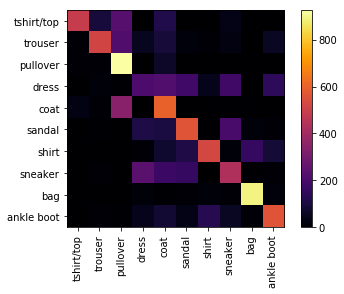

In [25]:
confuse_me(final_preds_small, labels_small)

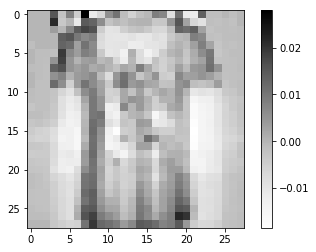

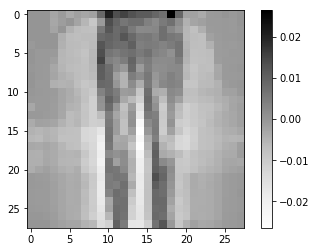

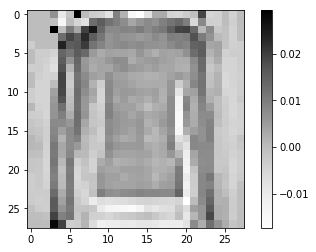

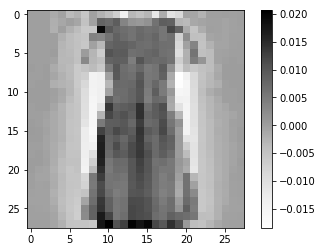

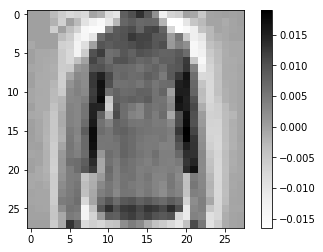

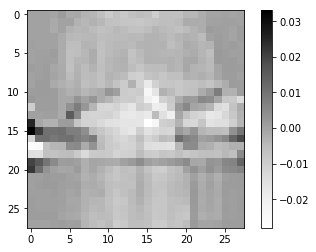

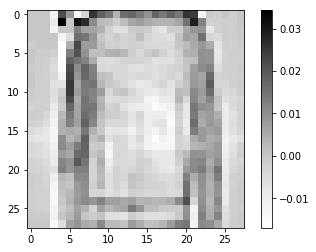

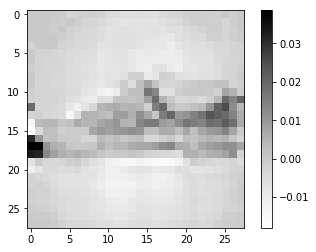

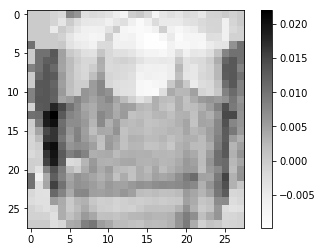

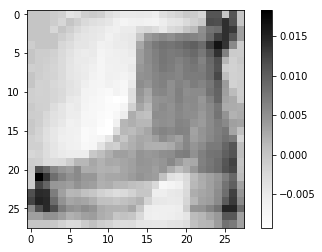

In [26]:
for i in range(10):
    visualize(chosen_model_small, i)

## Interpretation

- In a similar way to the large set, the visualize function shows the predicted values for a particular class with our best model.
- The visualization in the small validation set seems to be a lot better than in the large validation set.
- Perhaps the smaller amount of data allows this model to learn really well each class. 
- Our model has more weights than 30, and xTr has only 30 images. So it is possible that it is learning a weight per class.


